In [48]:
import os

In [49]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL ='http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [50]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [51]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [52]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [53]:
import object_detection

In [54]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [55]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [56]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [57]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [58]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [59]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [60]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [61]:
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [62]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [63]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [64]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [65]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'],'test', '1.jpeg')

Run All of The Above First and Then Run This to Detect a Plate

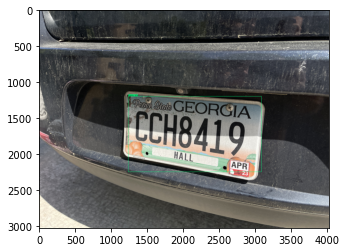

In [67]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [68]:
import easyocr

In [74]:
detection_threshold = 0.7

In [72]:
region_threshold = 0.2

In [76]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [70]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


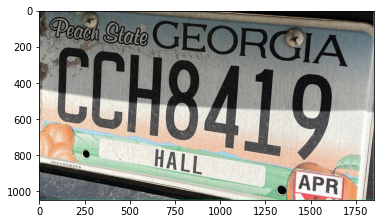

['CCH8419']


In [77]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

In [164]:
type(text)

list

In [78]:
print(text)

['CCH8419']


In [167]:
text.remove("Peach Ctate GEORGIA")

In [168]:
print(text)

['CC07012']


# Save Results

In [116]:
import csv
import uuid

In [202]:
'{}.jpg'.format(uuid.uuid1())

'096bde17-c671-11ec-b58b-7085c2af16db.jpg'

In [232]:
LCam_Path = '\\xampp\\htdocs\\LCam\\fromCam\\Detection_Images'
print(LCam_Path)
CSV_path = ('\\xampp\\htdocs\\LCam\\fromCam\\detection_results.csv')

\xampp\htdocs\LCam\fromCam\Detection_Images


In [233]:
def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(CSV_path, mode='a', newline='') as f:
        
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])
        
        

In [235]:
save_results(text, region, 'realtimeresults.csv', LCam_Path)

In [227]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try: 
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

ValueError: in user code:

    File "C:\Users\Parker\AppData\Local\Temp\ipykernel_15372\1007919961.py", line 11, in detect_fn  *
        image, shapes = detection_model.preprocess(image)
    File "C:\Users\Parker\licenseplate\detectorEnv\lib\site-packages\object_detection-0.1-py3.9.egg\object_detection\meta_architectures\ssd_meta_arch.py", line 484, in preprocess  *
        normalized_inputs, self._image_resizer_fn)
    File "C:\Users\Parker\licenseplate\detectorEnv\lib\site-packages\object_detection-0.1-py3.9.egg\object_detection\utils\shape_utils.py", line 492, in resize_images_and_return_shapes  *
        outputs = static_or_dynamic_map_fn(
    File "C:\Users\Parker\licenseplate\detectorEnv\lib\site-packages\object_detection-0.1-py3.9.egg\object_detection\utils\shape_utils.py", line 246, in static_or_dynamic_map_fn  *
        outputs = [fn(arg) for arg in tf.unstack(elems)]
    File "C:\Users\Parker\licenseplate\detectorEnv\lib\site-packages\object_detection-0.1-py3.9.egg\object_detection\core\preprocessor.py", line 3327, in resize_image  *
        new_image = tf.image.resize_images(

    ValueError: 'images' must have either 3 or 4 dimensions.
